# Recurrent Neural Networks I

Classical neural networks, including convolutional ones, suffer from two severe limitations:

+ They only accept a fixed-sized vector as input and produce a fixed-sized vector as output.
+ They do not consider the sequential nature of some data (language, video frames, time series, etc.) 

Recurrent neural networks overcome these limitations by allowing to operate over sequences of vectors (in the input, in the output, or both).

## Vanilla Recurrent Neural Network

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/vanilla.png?raw=true" alt="" style="width: 400px;"/>


## Unrolling in time of a RNN

By unrolling we mean that we write out the network for the complete sequence.

$$ s_t = \mbox{tanh }(Ux_t + W s_{t-1}) $$
$$ y_t = \mbox{softmax }(V s_t) $$

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/unrolling.png?raw=true" alt="" style="width: 600px;"/>
<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/TanhReal.gif?raw=true" alt="" style="width: 200px;"/>


## Vanilla Recurrent Neural Network (minibatch version)

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/minibatch.png?raw=true" alt="" style="width: 400px;"/>


+ We can think of the **hidden state** $s_t$ as a memory of the network that captures information about the previous steps.
+ The RNN **shares the parameters** $U,V,W$ across all time steps.
+ It is not necessary to have outputs $y_t$ at each time step.

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/kar.png?raw=true" alt="" style="width: 600px;"/>

<center>
Source: http://karpathy.github.io/2015/05/21/rnn-effectiveness/
</center>

RNN have shown success in:

+ Language modeling and generation.
+ Machine Translation.
+ Speech Recognition.
+ Image Description.
+ Question Answering.
+ Etc.

## RNN Computation

```python
class RNN:
    #...
    def step(self,x):
        self.h = np.tanh(np.dot(self.W_hh, self.h) + 
                 np.dot(self.W_xh, self.x))
        y = np.dot(self.W_hy, self.h)
        return y
    #...
```

We can go deep by stacking RNNs:
```python
y1 = rnn1.step(x)
y2 = rnn2.step(y1)
```

Training a RNN is similar to training a traditional NN, but some modifications. The main reason is that parameters are shared by all time steps: in order to compute the gradient at $t=4$, we need to propagate 3 steps and sum up the gradients. This is called **Backpropagation through time (BPTT)**.

The inputs of a recurrent network are always vectors, but we can process sequences of symbols/words by representing these symbols by numerical vectors.

Let's suppose we are classifying a series of words: $x_1, ..., x_{t-1}, x_t, x_{t+1}, ... x_{T}$ are the word vectors corresponding to a corpus with T symbols. Then, the relationship to compute the hidden layer output features at each time-step $t$ is $h_t = \sigma(W^{(hh)} h_{t-1} + W^{(hx)} x_{t})$, where:

   + $x_{t} \in \mathbb{R}^{d}$ is input word vector at time $t$. 
   + $W^{hx} \in \mathbb{R}^{D_h \times d}$ is the weights matrix used to condition the input word vector, $x_t$.
   + $W^{hh} \in \mathbb{R}^{D_h \times D_h}$ is the weights matrix used to condition the output of the previous time-step, $h_{t-1}$.
   + $h_{t-1}  \in \mathbb{R}^{D_h}$ is the output of the non-linear function at the previous time-step, $t-1$. 
   + $h_0 \in \mathbb{R}^{D_h}$ is an initialization vector for the hidden layer at time-step $t = 0$.
   + $\sigma ()$ is the non-linearity function (normally, ``tanh``).
   + $\hat{y}_t = softmax (W^{(S)}h_t)$ is the output probability distribution over the vocabulary at each time-step $t$.  Essentially, $\hat{y}_t$ is the next predicted word given the document context score so far (i.e. $h_{t-1}$) and the last observed word vector $x^{(t)}$. Here, $W^{(S)} \in \mathbb{R}^{|V| \times D_h}$ and $\hat{y} \in \mathbb{R}^{|V|}$ where $|V|$ is the vocabulary.

The loss function used in RNNs is often the cross entropy error:

$$
	L^{(t)}(W) = - \sum_{j=1}^{|V|} y_{t,j} \times log (\hat{y}_{t,j})
$$

The cross entropy error over a corpus of size $T$ is:

$$
	L = \dfrac{1}{T} \sum_{t=1}^{T} L^{(t)}(W) = - \dfrac{1}{T} \sum_{t=1}^{T} \sum_{j=1}^{|V|} y_{t,j} \times log (\hat{y}_{t,j})
$$


In the case of classifying a series of symbols/words, the *perplexity* measure can be used to assess the goodness of our model. It is basically 2 to the power of the negative log probability of the cross entropy error function:

$$
	Perplexity = 2^{L}
$$

Perplexity is a measure of confusion where lower values imply more confidence in predicting the next word in the sequence (compared to the ground truth outcome).

## RNN Training

Recurrent neural networks propagate weight matrices from one time-step to the next. Recall the goal of a RNN implementation is to enable propagating context information through faraway time-steps. When these propagation results in a long series of matrix multiplications, weights can vanish or explode. 

Once the gradient value grows extremely large, it causes an overflow (i.e. ``NaN``) which is easily detectable at runtime; this issue is called the *Gradient Explosion Problem*. 

When the gradient value goes to zero, however, it can go undetected while drastically reducing the learning quality of the model for far-away words in the corpus; this issue is called the *Vanishing Gradient Problem*.

### Gradient Clipping

To solve the problem of exploding gradients, Thomas Mikolov first introduced a simple heuristic solution that *clips* gradients to a small number whenever they explode. That is, whenever they reach a certain threshold, they are set back to a small number. 

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/exploding.png?raw=true" alt="" style="width: 400px;"/>


### Better initialization

To solve the problem of vanishing gradients, instead of initializing $W^{hh}$ randomly, starting off from **random orthogonal matrices** works better,  i.e., a square matrix $W$ for which $W^T W=I$.

There are two properties of orthogonal matrices that are useful for training deep neural networks:
+ they are norm-preserving, i.e., $ ||Wx||^2=||x||^2$, and
+ their columns (and rows) are all orthonormal to one another.

At least at the start of training, the first of these should help to keep the norm of the input constant throughout the network, which can help with the problem of exploding/vanishing gradients. 

Similarly, an intuitive understanding of the second is that having orthonormal weight vectors encourages the weights to learn different input features.

You can obtain a random $n \times n$ orthogonal matrix $W$, (uniformly distributed) by performing a QR factorization of an $n \times n$ matrix with elements i.i.d. Gaussian random variables of mean $0$ and variance $1$. Here is an example:

In [1]:
import numpy as np
from scipy.linalg import qr

n = 3
H = np.random.randn(n, n)
print(H)
print('\n')

Q, R = qr(H)

print (Q.dot(Q.T))
print(Q)

[[ 0.00471241  0.20250343  0.67828716]
 [-0.40961315  0.36636658  0.21412201]
 [ 0.18052579 -1.68407099  1.62059982]]


[[ 1.00000000e+00  4.40432839e-16 -1.46140146e-16]
 [ 4.40432839e-16  1.00000000e+00  1.76849036e-16]
 [-1.46140146e-16  1.76849036e-16  1.00000000e+00]]
[[-0.01052689  0.1512298  -0.98844258]
 [ 0.9150204  -0.39719676 -0.07051528]
 [-0.4032702  -0.90518743 -0.1341971 ]]


### Steeper Gates

We can make the "gates steeper" so they change more repidly from 0 to 1 and the model is learnt quicker.

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/steeper.png?raw=true" alt="" style="width: 600px;"/>


### Gated Units

The most important types of gated RNNs are:

+ Long Short Term Memories (LSTM). It was introduced by S.Hochreiter and J.Schmidhuber in 1997 and is widely used. LSTM is very good in the long run due to its high complexity.
+ Gated Recurrent Units (GRU). It was recently introduced by K.Cho. It is simpler than LSTM, fasters and optimizes quicker. 


#### LSTM

The key idea of LSTMs is the cell state $C$, the horizontal line running through the top of the diagram.

The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged.

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/lstm.png?raw=true" alt="Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/" style="width: 600px;"/> 

LSTM has the ability to remove or add information to the cell state, carefully regulated by structures called gates.

Gates are a way to optionally let information through. They are composed out of a *sigmoid* neural net layer and a pointwise multiplication operation.

Let us see how a LSTM uses $h_{t-1}, C_{t-1}$ and $x_{t}$ to generate the next hidden states $C_t, h_{t}$:

$$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t]) \mbox{ (Forget gate)} $$
$$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t]) \mbox{ (Input gate)} $$
$$ \tilde C_t = \operatorname{tanh}(W_C \cdot [h_{t-1}, x_t]) $$
$$ C_t = f_t * C_{t-1} + i_t * \tilde C_t \mbox{ (Update gate)} $$
$$ o_t = \sigma(W_o \cdot [h_{t-1}, x_t]) $$
$$ h_t = o_t * \operatorname{tanh}(C_t) \mbox{ (Output gate)} $$

There are other variants of LSTM (f.e. LSTM with peephole connections of Gers & Schmidhuber (2000))

#### GRU

The transition from hidden state $h_{t-1}$ to $h_{t}$ in vanilla RNN is defined by using an affine transformation and a point-wise nonlinearity. 

What motivates the use of gated units? Although RNNs can theoretically capture long-term dependencies, they are very hard to actually train to do this. Gated recurrent units are designed in a manner to have more persistent memory thereby making it easier for RNNs to capture long-term dependencies. 

<img src="https://github.com/DataScienceUB/DeepLearningfromScratch2018/blob/master/images/gru.png?raw=true"alt="" style="width: 300px;"/>
<center>
Source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/
</center>

Let us see how a GRU uses $h_{t-1}$ and $x_{t}$ to generate the next hidden state $h_{t}$.

$$ z_{t} = \sigma(W_z \cdot [x_{t}, h_{t-1}]) \mbox{ (Update gate)}$$
$$ r_{t} = \sigma(W_r \cdot [x_{t}, h_{t-1}]) \mbox{ (Reset gate)}$$
$$ \tilde{h}_{t} = \operatorname{tanh}(r_{t} \cdot  [x_{t}, r_t \circ h_{t-1}]   ) \mbox{ (New memory)}$$
$$ h_{t} = (1 - z_{t}) \circ \tilde{h}_{t-1} + z_{t} \circ h_{t} \mbox{ (Hidden state)}$$

It combines the forget and input gates into a single “update gate.” It also merges the cell state and hidden state, and makes some other changes. The resulting model is simpler than standard LSTM models.

## `keras`

> Keras is a high-level neural networks library, written in Python and capable of running on top of either TensorFlow or Theano. It was developed with a focus on enabling fast experimentation.

The core data structure of Keras is a model, a way to organize layers. The main type of model is the ``Sequential model``, a linear stack of layers. 

```Python
from keras.models import Sequential
model = Sequential()
```

Stacking layers is as easy as ``.add()``:

```Python
from keras.layers import Dense, Activation

model.add(Dense(output_dim=64, input_dim=100))
model.add(Activation("relu"))
model.add(Dense(output_dim=10))
model.add(Activation("softmax"))
```

Once your model looks good, configure its learning process with
``.compile()``:

```Python
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
```

If you need to, you can further configure your optimizer.

```Python
from keras.optimizers import SGD
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True))
```

You can now iterate on your training data in batches:

```Python
model.fit(X_train, Y_train, nb_epoch=5, batch_size=32)
```

Evaluate your performance in one line:
```Python
loss_and_metrics = model.evaluate(X_test, Y_test, batch_size=32)
```

Or generate predictions on new data:

```Python
classes = model.predict_classes(X_test, batch_size=32)
proba = model.predict_proba(X_test, batch_size=32)
```

### RNN in Keras

Whenever you train or test your LSTM/GRU, you first have to build your input matrix $X$ of shape ``nb_samples``, ``timesteps``, ``input_dim`` where your batch size divides ``nb_samples``. 

For instance, if ``nb_samples=1024`` and ``batch_size=64``, it means that your model will receive blocks of 64 samples, compute each output (whatever the number of timesteps is for every sample), average the gradients and propagate it to update the parameters vector. 

> By default, **Keras shuffles (permutes) the samples in $X$** and the dependencies between $X_i$ and $X_{i+1}$ are lost. 

With the stateful model, all the states are propagated to the next batch. It means that the state of the sample located at index $i$, $X_i$, will be used in the computation of the sample $X_{i+bs}$ in the next batch, where $bs$ is the batch size (no shuffling).

> Keras requires the batch size in ``stateful`` mode and ``shuffle=False``.

Generating Data
Input shape: (50000, 1, 1)
Output shape
(50000, 1)
Sample:  [[100.]] [99.98797429]


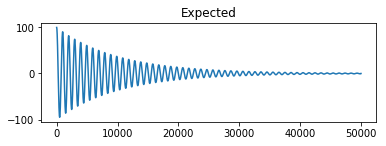

In [3]:
'''Example script showing how to use stateful RNNs
to model long sequences efficiently.
'''

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM, GRU
%matplotlib inline

# since we are using stateful rnn tsteps can be set to 1
tsteps = 1
batch_size = 25

# number of elements ahead that are used to make the prediction
lahead = 1


def gen_cosine_amp(amp=100, period=25, x0=0, xn=50000, step=1, k=0.0001):
    """Generates an absolute cosine time series with the amplitude
    exponentially decreasing
    Arguments:
        amp: amplitude of the cosine function
        period: period of the cosine function
        x0: initial x of the time series
        xn: final x of the time series
        step: step of the time series discretization
        k: exponential rate
    """
    cos = np.zeros(((xn - x0) * step, 1, 1))
    for i in range(len(cos)):
        idx = x0 + i * step
        cos[i, 0, 0] = amp * np.cos(idx / (2 * np.pi * period))
        cos[i, 0, 0] = cos[i, 0, 0] * np.exp(-k * idx)
    return cos


print('Generating Data')
cos = gen_cosine_amp()
print('Input shape:', cos.shape)

expected_output = np.zeros((len(cos), 1))
for i in range(len(cos) - lahead):
    expected_output[i, 0] = np.mean(cos[i + 1:i + lahead + 1])

print('Output shape')
print(expected_output.shape)
print("Sample: ",cos[0], expected_output[0])

plt.subplot(2, 1, 1)
plt.plot(expected_output)
plt.title('Expected')
plt.show()

Creating Model
Training
Epoch 0 / 25


/usr/local/lib/python3.5/dist-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/1
50000/50000 [==============================] - 11s 215us/step - loss: 365.9475
Predicting
Ploting Results


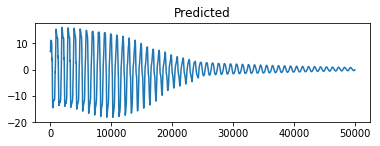

Epoch 1 / 25
Epoch 1/1
32550/50000 [==================>...........] - ETA: 3s - loss: 314.3629

KeyboardInterrupt: 

In [4]:
epochs = 25

print('Creating Model')
model = Sequential()
model.add(LSTM(50,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=True,
               stateful=True))
model.add(LSTM(50,
               batch_input_shape=(batch_size, tsteps, 1),
               return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')

print('Training')
for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,
              expected_output,
              batch_size=batch_size,
              verbose=1,
              nb_epoch=1,
              shuffle=False)
    model.reset_states()

    print('Predicting')
    predicted_output = model.predict(cos, batch_size=batch_size)

    print('Ploting Results')
    plt.subplot(2, 1, 1)
    plt.plot(predicted_output)
    plt.title('Predicted')
    plt.show()

## Keras online demo

https://transcranial.github.io/keras-js/#/